# DataGym
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [2]:
df_descr = pd.read_csv('otp_description.csv', sep='\t', encoding='utf8')

In [41]:
df_descr.head()

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,AGE,возраст клиента
2,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
3,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
4,GENDER,"пол клиента (1- женщины, 0-мужчины)"


Считаем обучающую выборки и тестовую (которую мы как бы не знаем)

In [4]:
df_train = pd.read_csv('otp_train.csv', sep='\t', encoding='utf8')

In [5]:
df_train.shape

(15223, 52)

In [6]:
df_test = pd.read_csv('otp_test.csv', sep='\t', encoding='utf8')

In [7]:
df_test.shape

(14910, 52)

In [8]:
df_train.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,...,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,...,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,...,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,...,1,1,1,1,6,3,1,"1589,92333333333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,...,0,1,2,1,16,2,1,"1152,15",2230,NaN


## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [9]:
df_train['sample'] = 'train'
df_test['sample'] = 'test'

In [10]:
df = df_test.append(df_train).reset_index(drop=True)

In [11]:
df.shape

(30133, 53)

### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [ ]:
df.info()

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [ ]:
for i in df.columns:                      # перебираем все столбцы
    if str(df[i].dtype) == 'object':      # если тип столбца - object
        print('='*10)
        print(i)                                # выводим название столбца
        print(set(df[i]))                 # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n')                             # выводим пустую строку

Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [ ]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')
# так это исправляется, но результат не записывается никуда)

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Заполните их нулями

In [15]:
df = df.fillna(0)

#### Задание 2. В данных есть признаки, которые можно назвать категориальным, например семейный статус
 {'Состою в браке', 'Разведен(а)', 'Не состоял в браке', 'Вдовец/Вдова', 'Гражданский брак'}
 и таких много
#### Закодируйте их числами (например идентификаторами 1, 2, 3, ... )
#### Можно иначе, если есть идеи как.

In [16]:
cat_col = ['MARITAL_STATUS']

for col in cat_col:
    vals = set(df[col].values)
    dct = dict(zip(vals, range(len(vals))))
    #df['CAT_{}'.format(col)] = df[col].map(dct)

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками (см задание 1)
* Кодировала категориальные признаки (см задание 2) Если закодировать признаки вам не удалось - удалите все что не числа

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [17]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    df_output.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # изменение типов данных
    cols_to_change_type = ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    for col in cols_to_change_type:
        df_output[col] = df_output[col].map(lambda x: x.replace(',', '.')).astype('float')
    
    # заполнение пропусков
    df_output = df.fillna(0)
    
    # кодировка категориальных переменных
    for cat_col in df_output.drop('sample', axis=1).select_dtypes(include='object').columns:
        try:
            vals = set(df_output[cat_col].values)
            dct = dict(zip(vals, range(len(vals))))
            df_output[cat_col] = df_output[cat_col].map(dct)
        except:
            df_output.drop(cat_col, axis=1, inplace=True)
        
    return df_output

In [18]:
df_preproc = df.pipe(preproc_data) # применит вашу написанную выше функцию к датафрейму и вернут новый

In [19]:
df_preproc.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,sample
0,59909969,0,30,1,0,1,1,1,0,0,...,1,2,2,8,0,0,541,458,0.0,test
1,59910420,0,48,0,1,1,0,0,5,2,...,0,2,1,15,0,0,541,458,0.0,test
2,59911223,0,35,1,0,0,1,0,5,0,...,1,1,1,1,0,0,541,458,0.0,test
3,59911322,0,22,1,0,0,0,0,5,0,...,1,3,2,9,0,0,541,458,0.0,test
4,59911438,0,27,1,0,1,2,2,2,2,...,1,1,1,5,0,0,541,458,0.0,test


In [20]:
df_preproc.select_dtypes(include='object').head()

,sample
0,test
1,test
2,test
3,test
4,test


#### Задание 4. Выше мы собрали данные в один датафрейм и записали столбец sample, чтоб было видно где что осталось.
#### ... напишите код, который разделит df_preproc на 2 части train и test (записав в df_train_preproc и df_test_preproc соответственно)
#### ... удалив колонку sample

In [21]:
df_train_preproc = df_preproc[df_preproc['sample']=='train'].drop('sample', axis=1)
df_test_preproc  = df_preproc[df_preproc['sample']=='test'].drop('sample', axis=1)

#### Задание 5. Отделите целевую переменную и остальные признаки (речь не про train_test_split)
Выше у вас получились матрицы df_train_preproc и df_test_preproc

Должно получится:
* 2 матрицы: X и X_valid
* 2 вектора: y и y_valid


* где X - все данные df_train_preproc, кроме TARGET
* где X_valid - все данные df_test_preproc, кроме TARGET
* где y - TARGET от df_train_preproc
* где y_valid - TARGET от df_test_preproc

In [22]:
X = df_train_preproc.drop('TARGET', axis=1)
y = df_train_preproc['TARGET']

X_valid = df_test_preproc.drop('TARGET', axis=1)
y_valid = df_test_preproc['TARGET']

#### Задание 6. Обучение и оценка качества разных моделей

In [23]:
# Поделите данные X и y на 2 части (train и test, размером от исходного 70% и 30% соответственно)

from sklearn.model_selection import train_test_split

X_train, X_test, y_tarin, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
print('train shape: {}'.format(y_tarin.shape[0]))
print('test  shape: {}'.format(y_test.shape[0]))

train shape: 10656
test  shape: 4567


In [25]:
# Попробовать следующие "черные ящики": интерфейс у всех одинаковый 
# Постепенно мы узнаем, что они делаютб а сейчас учимся выбирать какой работает качественнее
#     fit, 
#     predict
# записав предсказания в pred_1, pred_2, pred_3

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

tree = DecisionTreeClassifier()
rf   = RandomForestClassifier()
lr   = LogisticRegression()

In [26]:
tree.fit(X_train, y_tarin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
rf.fit(X_train, y_tarin)

/Users/antonina.goryacheva/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
lr.fit(X_train, y_tarin)

/Users/antonina.goryacheva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
pred_1 = tree.predict(X_test)
pred_2 = rf.predict(X_test)
pred_3 = lr.predict(X_test)

In [30]:
# Посчитать метрики стандартные
# accuracy, precision, recall, а1
# в pred_1, pred_2, pred_3 у вас должны лежать предсказания разных "ящиков"
# посчитайте метрики для каждого

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
accuracy_list = [accuracy_score(y_test, pred) for pred in [pred_1, pred_2, pred_3]]
precision_list = [precision_score(y_test, pred) for pred in [pred_1, pred_2, pred_3]]
recall_list = [recall_score(y_test, pred) for pred in [pred_1, pred_2, pred_3]]
f1_list = [f1_score(y_test, pred) for pred in [pred_1, pred_2, pred_3]]

/Users/antonina.goryacheva/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/antonina.goryacheva/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


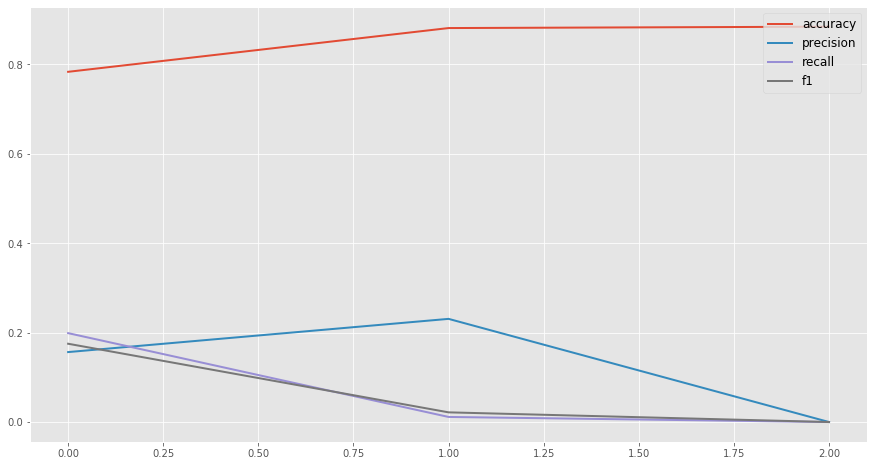

In [36]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить  качество)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает
plt.figure(figsize=(15, 8))

lw = 2
fs = 12

plt.plot(accuracy_list, label='accuracy', linewidth=lw);
plt.plot(precision_list, label='precision', linewidth=lw);
plt.plot(recall_list, label='recall', linewidth=lw);
plt.plot(f1_list, label='f1', linewidth=lw);
plt.legend(loc='upper right', fontsize=fs);

In [37]:
pd.DataFrame([accuracy_list, precision_list, recall_list, f1_list], 
            columns=['Decision Tree', 'Random Forest', 'Logistic Regression'],
            index=['accuracy', 'precision', 'recall', 'f1'])

,Decision Tree,Random Forest,Logistic Regression
accuracy,0.783446,0.881323,0.884388
precision,0.156483,0.230769,0.000000
recall,0.198864,0.011364,0.000000
f1,0.175146,0.021661,0.000000


#### Задание 7. Заключительное.
#### Выше вы можете выборать самую лучшую модель "коробочку" по метрике F1
#### Теперь вы знаете какой тип коробочки из представленных лучше всего работает на данной задаче
#### Пора: 1) заново объявить эту коробочку
#### 2) обучить на всем X,y
#### 3) протестировать на отложенном X_valid, y_valid

In [38]:
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
# Взять лучшую модель и сделать предсказания для X_valid выборки
pred_final = tree.predict(X_valid)

In [40]:
# Посчитать метрики на полученном предсказании
print('accuracy_score: {}'.format(accuracy_score(y_valid, pred_final)))
print('precision_score: {}'.format(precision_score(y_valid, pred_final)))
print('recall_score: {}'.format(recall_score(y_valid, pred_final)))
print('f1_score: {}'.format(f1_score(y_valid, pred_final)))

accuracy_score: 0.7918175720992623
precision_score: 0.1503099173553719
recall_score: 0.1662857142857143
f1_score: 0.15789473684210528
